# Post Regrid Data Handling

Goal is to have a streamlined way to access the files needed given a set of parameters. Envisioning something where a user could enter:
* Sectors of interest
* Timerange of interest
* Spatial bounding box
* Gas species of interest    

And be returned either an xarray object with dask parallelization, or create a new nc/set of nc files to be loaded by the user later. 

There is obviously lots of work to be done, but this is a good start if you want to start playing with data. 


In [10]:
import xarray as xr
import pandas as pd
import os
import pyproj
import numpy as np
import xesmf as xe
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

import noaa_csl_funcs as ncf
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Working on this class. More to do, but the cells below should work
TODO is merging point and area data effectively. More in the readme

In [11]:
class Regridded_CSL_Handler:
    '''A class to handle NOAA CSL inventory data that has been regridded and organized by regrid_data.py'''

    def __init__(self,regridded_path,bau_or_covid='COVID'):
        '''Everything revolves around the "regridded_path", which determines sectors via the filenames contained within'''

        self.regridded_path = regridded_path
        self.sectors = self.get_sectors()
        self.bau_or_covid = bau_or_covid

    def get_sectors(self):
        '''Lists the sectors in the regridded data storage path'''

        sector_list = ncf.listdir_visible(self.regridded_path)
        sectors = {'area':[],'point':[]}
        for sector in sector_list:
            if 'area' in sector:
                sectors['area'].append(sector)
            elif 'point' in sector:
                sectors['point'].append(sector)
            else:
                raise ValueError(f"Unexpected sector type {sector}, not point or area.")
        return sectors

    def get_sector_subset_list(self,sector_subset):
        '''Gets a subset of the sectors which could be one, all, or some
        
        Args:
        sector_subset (str,list): "all" will return all sectors,  'point' will return point sectors, 'area' will return area sectors, a list will just return that list
        
        Returns:
        sector_subset_list (list) : list of sectors in the subset. 
        '''

        if sector_subset == 'all':
            sector_subset_list = []
            for k,v in self.sectors.items():
                sector_subset_list.extend(v)
            return sector_subset_list
        elif type(sector_subset)==str:
            return self.sectors[sector_subset]
        else:
            return sector_subset

    def get_days_in_range(self,dt1,dt2,day_types,sector_subset = 'all',add_path=True):
        '''Gets all filepaths to the day_type level that are within a datetime range
        
        Args:
        dt1 (datetime.date) : a date, datetime, etc to start the range (will only use year and month)
        dt2 (datetime.date) : a date, datetime, etc to end the range (will only use year and month)
        sectors (list) : list of sectors to include in the list
        day_types (list) : list of day types to include in the list
        add_path (bool, optional) : if true (default) it will add the regridded path to each element

        Returns:
        days_in_range (list) : list of paths to files that are within the date range and sector, day_types, etc. 
        '''

        dates_list = pd.date_range(dt1,dt2,freq = 'MS') #get a list of all the months between the dts
        sector_subset_list = self.get_sector_subset_list(sector_subset)
        days_in_range = []
        for date in dates_list:
            for sector in sector_subset_list:
                for day_type in day_types:
                    day_path = f'{sector}/{ncf.yr_to_yrstr(sector,date.year,self.bau_or_covid)}/{ncf.month_int_to_str(date.month)}/{day_type}'
                    if add_path:
                        days_in_range.append(os.path.join(self.regridded_path,day_path))
                    else:
                        days_in_range.append(day_path)
        return days_in_range
    
    def get_files_in_days(self,days_paths):
        '''Gets the files that exist in the paths
        
        Args:
        days_path (list) : list of paths to the days folders
        
        Returns:
        files (list) : list of files in those days' paths'''

        files = []
        for day_path in days_paths:
            files.extend(ncf.listdir_visible(day_path,add_path=True))
        return files

def preprocess_regridded(ds):
    '''Preprocesses the regridded dataset when loaded to add attributes needed for concatenation
    
    Args:
    ds (xr.DataSet) : the dataset to process
    
    Returns 
    ds (xr.DataSet) : the dataset, with added coordinates taken from the attributes
    '''

    ds = ds.assign_coords(sector = 'area_'+ ds.attrs['sector_id']) #add back the area, was cut off in attributes for some reason
    ds = ds.assign_coords(day_type = ds.attrs['day_type']) 
    ds = ds.assign_coords(yr_mo=f'{ds.attrs['year']}-{ds.attrs['month']}')
    ds = ds.expand_dims(dim=['sector','day_type','yr_mo'])
    del ds.attrs['nc_fpath']
    return ds


In [12]:
## Define parameters of what we want to load
## ** NOTE this has not been stress tested. 
##    There is also surely a better way to deal with the year - month - day_type dilemna. It is a strange way of 
##    having to handle data because it is not truly "daily" and the month-day of week is nonstandard. 
##    Just a first go here. 
 
regridded_path = '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/regridded'
RCH = Regridded_CSL_Handler(regridded_path)
dt1  = '2019-01' #start year and month
dt2 = '2019-02' #end year and month
day_types = ['weekdy','satdy'] #a list with any or all of 'weekdy','satdy','sundy'
sectors = ['area_Industry','area_onroad_gasoline'] #a list of any area sectors (havent gotten to integrating point sources yet)
species = ['CO2','HC01'] #CO2 and methane

#Get the paths to the files that match the criteria
days_paths = RCH.get_days_in_range(dt1,dt2,day_types,sectors) 
files = RCH.get_files_in_days(days_paths)

In [13]:
#Load the files with xarray, preprocessing them so they can be combined by coordinates
ds_list = [] #initialize the list of datasets
for file in files:
    ds = preprocess_regridded(xr.open_dataset(file,chunks = {'utc_hour':1}))[species] #prepreprocess the file, open with dask chunking, and only keep the species of interest
    ds_list.append(ds)  

ds_combined = xr.combine_by_coords(ds_list,combine_attrs='drop_conflicts') #this is the combined dataset!
ds_combined

<xarray.Dataset>
Dimensions:   (sector: 2, day_type: 2, yr_mo: 2, utc_hour: 24, lat: 390,
               lon: 790)
Coordinates:
  * utc_hour  (utc_hour) int64 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
  * lat       (lat) float64 19.0 19.1 19.2 19.3 19.4 ... 57.6 57.7 57.8 57.9
  * lon       (lon) float64 -138.0 -137.9 -137.8 -137.7 ... -59.3 -59.2 -59.1
  * sector    (sector) <U20 'area_Industry' 'area_onroad_gasoline'
  * day_type  (day_type) <U6 'satdy' 'weekdy'
  * yr_mo     (yr_mo) <U6 '2019-1' '2019-2'
Data variables:
    CO2       (sector, day_type, yr_mo, utc_hour, lat, lon) float64 dask.array<chunksize=(1, 1, 1, 1, 390, 790), meta=np.ndarray>
    HC01      (sector, day_type, yr_mo, utc_hour, lat, lon) float64 dask.array<chunksize=(1, 1, 1, 1, 390, 790), meta=np.ndarray>
Attributes:
    grid_type:  area
    year:       2019
    git_sha:    bc7d70102e5509ecec2799fff7032a45afb1c44f

Now we can start to play with subsetting and representing data. 

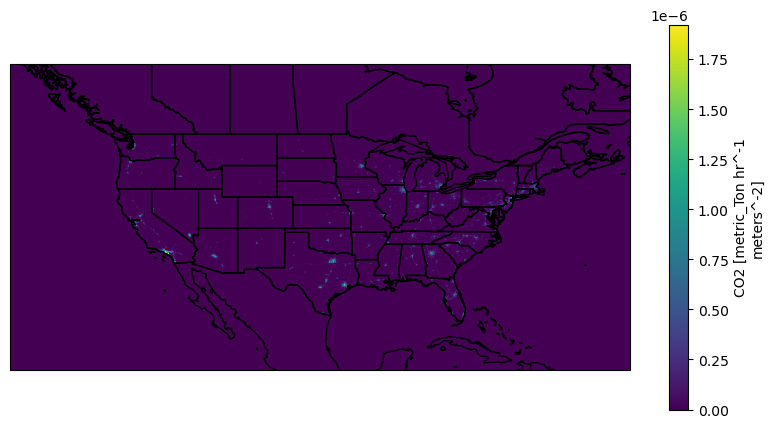

In [18]:
# For example:
# This is the mean daily emission rate of CO2 from onroad_gasoline vehicle on a weekday in Jan 2019 in the whole US
spec = 'CO2'
plotds = ds_combined.sel(sector='area_onroad_gasoline',
                         day_type='weekdy',
                         yr_mo='2019-1'
                         )[spec].mean(dim='utc_hour',keep_attrs=True)

#Plotting
proj = ccrs.PlateCarree() #set the projection
fig = plt.figure(figsize=(10,5)) #setup the figure
ax = plt.axes(projection = proj) #setup the axis with correct projection
plotds.plot.pcolormesh('lon','lat',ax = ax,cmap = 'viridis') #plot the dataset on the ax 
ax.coastlines() #add coastlines
ax.add_feature(cfeature.BORDERS) #borders 
ax.add_feature(cfeature.STATES) #states
plt.title('')
plt.show() #show it

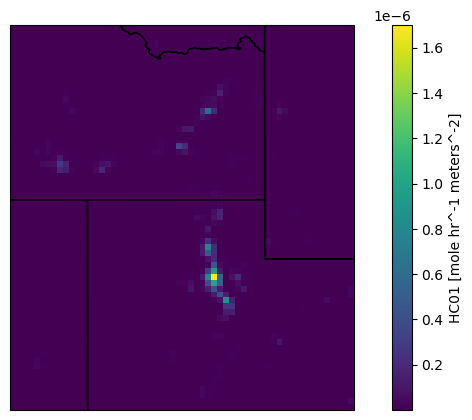

In [19]:
#This is the mean daily emission rate of methane (HC01) from industry on a saturday in Febuary 2019 near northern Utah
# TODO This takes a long time. Find the bottleneck. Suspect it is the lat lon slicing? why tho...
map_extent={'lon_low':-115.4,

            'lon_high':-109.6,
            'lat_low':38.5,
            'lat_high':45.0} #define the extent

plotds = ds_combined.sel(sector='area_Industry',day_type='satdy',yr_mo='2019-2', #sector day type and month
                         lat=slice(map_extent['lat_low'],map_extent['lat_high']), 
                         lon=slice(map_extent['lon_low'],map_extent['lon_high']) #subselect the bounding box in lat lon
                         )['HC01'].mean(dim='utc_hour',keep_attrs = True) #take methane (HC01) and the mean hourly

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection = proj)
plotds.plot.pcolormesh('lon','lat',ax = ax,cmap = 'viridis')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.title('')
plt.show()

If we wanted to save the dataset to a .nc file for later use:

In [53]:
full_save_path = '/uufs/chpc.utah.edu/common/home/u0890904/test/test_save.nc'
ds_combined.to_netcdf(full_save_path)